In [1]:
import re
import os
import glob
import mahotas as mh
import numpy
import pylab as plt
import shutil
import matplotlib.patches as patches

%matplotlib inline

def compute_bb(img, label):
    bb = BoundingBox()
    bb.from_img(img, label)
    return bb

def plot_bb(img, bb, label, subplot) :
    a = plt.subplot(subplot)
    plt.imshow(img)
    plt.title('Merge label ' + str(label))
    bb.draw_subplot(a)

def plot_sp(img, l, subplot):
    plt.subplot(subplot)
    plt.imshow(img == l)
    plt.title('Label ' + str(l))
    
def plot_merge(img_merge, img_gt, l1, gt_l1, gt_l2):
    # Compute bounding boxes
    bb_i1 = compute_bb(img_merge, l1)
    bb_gt1 = compute_bb(img_gt, gt_l1)
    bb_gt2 = compute_bb(img_gt, gt_l2)
    
    plt.figure(1, figsize=(16, 8))
    plot_bb(img_merge, bb_i1, l1, 231)
    plot_bb(img_gt, bb_gt1, gt_l1, 232)
    plot_bb(img_gt, bb_gt2, gt_l2, 233)
    plot_sp(img_merge, l1, 234)
    plot_sp(img_gt, gt_l1, 235)
    plot_sp(img_gt, gt_l2, 236)
    

def plot_figure(img, title=None, colorbar=False):
    fig = plt.figure()
    plt.imshow(img)
    if colorbar is True:
        plt.colorbar()
    if title is not None:
        plt.title(title)
    return fig

class Point:
    """ Point class represents and manipulates x,y coords. """

    def __init__(self, x, y):
        """ Create a new point at the origin """
        self.x = x
        self.y = y
    
    def __str__(self):
        return '(' + str(self.x) + ',' + str(self.y) + ')'
        
class BoundingBox:
    """ BoundingBox represents the minimal square a superpixel is embedded into """
    
    # Points are input in a clock-wise order
    def __init__(self, tl=None, tr=None, br=None, bl=None):
        self.tl = tl
        self.tr = tr
        self.bl = bl
        self.br = br
    
    def height(self):
        return abs(self.br.x - self.tr.x)
    
    def width(self):
        return abs(self.tl.y - self.tr.y)
        
    # Fills boudning box info from image and corresponding cluster identifier
    def from_img(self, img, sp_id):
        values = img == sp_id
        if values.any() == False:
            raise Exception("There is no cluster with the id {}'".format(str(sp_id)))
        pos = numpy.where(values)
        self.tl = Point(min(pos[0]), min(pos[1]))
        self.tr = Point(min(pos[0]), max(pos[1]))
        self.br = Point(max(pos[0]), max(pos[1]))
        self.bl = Point(max(pos[0]), min(pos[1]))
    
    # Given current bounding box and a second one, define maximal bounding box for both
    def max_bb(self, other):
        min_h = min(self.tl[0], other.tl[0])
        min_w = min(self.tl[1], other.tl[1])
        max_h = max(self.br[0], other.br[0])
        max_h = max(self.br[1], other.br[1])
        return BoundingBox(Point(min_h, min_w), Point(min_h, max_w),
                           Point(max_h, max_w), Point(max_h, min_w))
    
    # Draws the bounding box in the current open window
    def draw(self, fig):
        ax = fig.gca()
        ax.add_patch(patches.Rectangle((self.tl.y, self.tl.x), self.width(), self.height(), 
                                       linewidth=2, fill=False, edgecolor='red'))
        
    # Draws the bounding box in the current open window
    def draw_subplot(self, ax):
        ax.add_patch(patches.Rectangle((self.tl.y, self.tl.x), self.width(), self.height(), 
                                       linewidth=2, fill=False, edgecolor='red'))
    
    # Prints the bounding box and its context given the input margin in pixels
    def look_at(self, img, margin):
        
        if self.tl.x - margin < 0 or self.bl.x + margin > img.shape[0]:
            raise Exception("Margin exceeds vertical margins of the image")
            
        if self.tl.y - margin < 0 or self.tr.x + margin > img.shape[1]:
            raise Exception("Margin exceeds horizontal margins of the image")
        
        subimage = img[(self.tl.x - margin):(self.bl.x + margin), 
                       (self.tl.y - margin):(self.tr.y + margin)]
        # Compute translated bounding box
        new_bb = BoundingBox(Point(margin, margin), 
                             Point(margin, margin + self.width()),
                             Point(margin + self.height(), margin + self.width()), 
                             Point(margin + self.height(), margin))
        # Print translated boundig box
        fig = plot_figure(subimage, '', True)
        ax = fig.gca()
        ax.add_patch(patches.Rectangle((new_bb.tl.y, new_bb.tl.x), self.width(), self.height(), 
                                       linewidth=2, fill=False, edgecolor='red'))
        
    def __str__(self):
     return str(self.tl) + ';' + str(self.tr) + str(self.br) + ';' + str(self.bl)

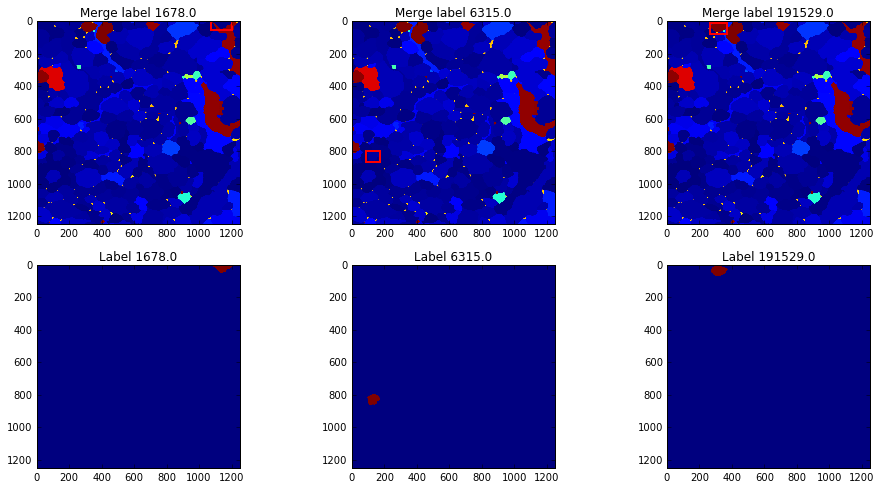

In [2]:
ident = 0
img = mh.imread('/home/morad/data/cremi/groundtruth/sampleA/' + str(ident).zfill(4) + '.tif')
gt = mh.imread('/home/morad/data/cremi/groundtruth/sampleA/' + str(ident).zfill(4) + '.tif')
plot_merge(img, gt, 1678.0, 6315.0, 191529.0)

(9,671);(9,941)(181,941);(181,671)


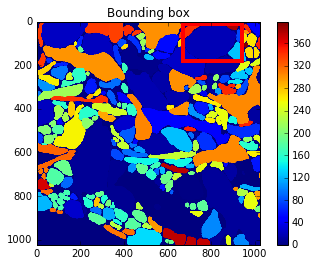

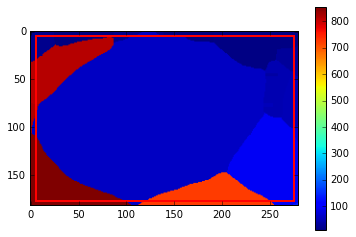

In [33]:
fig = plot_figure(gt, 'Bounding box', True)
bb_g.draw(fig)
bb_g.look_at(img, 5)
print bb_g.__str__()

(53,159);(53,194)(86,194);(86,159)


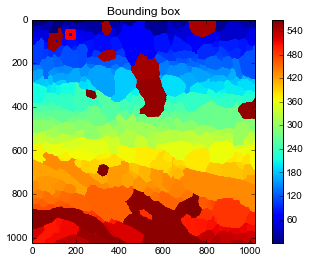

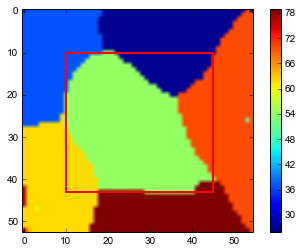

In [44]:
fig = plot_figure(img, 'Bounding box', True)
bb.draw(fig)
bb.look_at(img, 10)
print bb.__str__()

In [42]:
# Identify in which merges is background involved with just another label
#  e.g. 61    0    19
root = '/home/dmora/neural/snemi/00_prepare_data/notebooks/data'
merge_files = glob.glob(root + "/*.merges.data")
total = 0
backg = 0
for i in merge_files:
    with open(i) as f:
        content = f.readlines()
        for line in content:
            clus = re.split('\t', line)
            others = numpy.asarray(clus[0:])
            if len(clus) == 4 and '0' in others:
                backg += 1
            total += 1

ratio = float(backg)/float(total)
print 'Ratio of background merges: {}'.format(ratio)

Ratio of background merges: 0.941818181818


In [107]:
# Now let's get a list of merges that are not 'background merges'
#  e.g. 61    0    19
root = '/home/dmora/neural/snemi/00_prepare_data/notebooks/data'
merge_files = glob.glob(root + "/*.merges.data")
total = 0
backg = 0
l = dict()

def add_to_dict(d, img, values):
    if not img in d:
        d[img] = []
    d[img].append(values)

def get_img_id(path):
    name = os.path.basename(path)
    return re.split('\.', name)[0]
    
for i in merge_files:
    with open(i) as f:
        content = f.readlines()
        for line in content:
            clus = re.split('\t', line)
            others = numpy.asarray(clus[0:])
            if len(clus) > 4 or (not '0' in others):
                values = numpy.asarray(clus[:-1]).astype(int)
                add_to_dict(l, get_img_id(i), values)

print l


TypeError: only length-1 arrays can be converted to Python scalars

In [113]:
import csv
w = csv.writer(open(os.path.join(root, "non-background_merges.csv"), "w"), delimiter=',')

for i in merge_files:
    with open(i) as f:
        content = f.readlines()
        for line in content:
            clus = re.split('\t', line)
            others = numpy.asarray(clus[0:])
            if len(clus) > 4 or (not '0' in others):
                values = numpy.asarray(clus[:-1]).astype(int)
                row = [int(get_img_id(i))] + values.tolist()
                w.writerow([get_img_id(i)] + values.tolist())


[88, 829, 0, 23, 89]
[89, 102, 0, 6, 12]
[7, 1132, 1, 363]
[19, 221, 0, 22, 335]
[19, 293, 14, 301]
[19, 806, 53, 304]
[19, 907, 1, 362]
[19, 921, 159, 258]
[73, 462, 18, 46]
[73, 651, 0, 7, 57]
[57, 291, 16, 357]
[34, 207, 101, 110]
[9, 863, 1, 363]
[9, 945, 0, 65, 116]
[92, 465, 120, 301]
[92, 571, 0, 187, 227]
[92, 708, 0, 22, 291]
[92, 800, 78, 127]
[91, 164, 133, 304]
[48, 445, 20, 264]
[48, 954, 0, 1, 6]
[49, 397, 82, 118]
[49, 800, 41, 66]
[49, 975, 0, 6, 273]
[6, 80, 19, 304]
[76, 611, 185, 186]
[10, 949, 0, 7, 363]
[72, 502, 18, 46]
[72, 1024, 301, 353]
[79, 16, 343, 383]
[5, 891, 0, 101, 303]
[5, 928, 1, 363]
[58, 245, 0, 32, 54]
[58, 899, 0, 6, 60]
[58, 947, 0, 6, 214]
[58, 995, 41, 89]
[17, 234, 22, 159]
[17, 713, 0, 10, 335]
[32, 945, 0, 101, 257]
[96, 626, 0, 187, 376]
[96, 770, 0, 24, 338]
[33, 877, 0, 21, 287]
[33, 968, 0, 302, 304]
[55, 871, 0, 6, 357]
[87, 1, 0, 24, 51]
[87, 872, 168, 306]
[39, 963, 0, 104, 302]
[50, 344, 14, 244]
[66, 221, 81, 304]
[66, 495, 155, 159